# Face Generation using Deep Convolutional GANs

## Preminimaries

In [1]:
!pip install -q --upgrade wandb

     |████████████████████████████████| 1.9 MB 13.1 MB/s 
     |████████████████████████████████| 174 kB 63.0 MB/s 
     |████████████████████████████████| 182 kB 48.9 MB/s 
     |████████████████████████████████| 62 kB 777 kB/s 
     |████████████████████████████████| 173 kB 71.1 MB/s 
     |████████████████████████████████| 168 kB 92.2 MB/s 
     |████████████████████████████████| 168 kB 73.2 MB/s 
     |████████████████████████████████| 166 kB 71.9 MB/s 
     |████████████████████████████████| 166 kB 68.9 MB/s 
     |████████████████████████████████| 162 kB 91.6 MB/s 
     |████████████████████████████████| 162 kB 73.1 MB/s 
     |████████████████████████████████| 158 kB 50.3 MB/s 
     |████████████████████████████████| 157 kB 70.4 MB/s 
     |████████████████████████████████| 157 kB 69.3 MB/s 
     |████████████████████████████████| 157 kB 52.6 MB/s 
     |████████████████████████████████| 157 kB 85.6 MB/s 
     |████████████████████████████████| 157 kB 70.7 MB/s 
     |██████████

In [2]:
# Wandb Login
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
%%capture

!wget https://www.dropbox.com/s/rbajpdlh7efkdo1/male_female_face_images.zip
!unzip -q male_female_face_images.zip

In [21]:
!pip install -q --upgrade torch_snippets
from torch_snippets import *

import cv2
import torch 
import torchvision
from torchvision import transforms
import torchvision.utils as vutils

import numpy as np
import pandas as pd

import glob
from tqdm import tqdm

import matplotlib.pyplot as plt

---

## Configuration

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# wandb config
WANDB_CONFIG = { 
              '_wandb_kernel': 'neuracort'
    }

---

## Crop Images to Obtain Faces

In [7]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [8]:
!mkdir cropped_faces
images = Glob('/content/females/*.jpg')+Glob('/content/males/*.jpg')
for i in range(len(images)):
    img = read(images[i],1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        img2 = img[y:(y+h),x:(x+w),:]
    cv2.imwrite('cropped_faces/'+str(i)+'.jpg',cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))

In [ ]:
table_train = wandb.Table(columns=['Image'], allow_mixed_types = True)

In [ ]:
for image in glob.glob("/content/cropped_faces/*"):
  table_train.add_data(
            wandb.Image(image), 
        )
  
wandb.log({"Cropped Training Images" : table_train})

---

## Apply Transformations

In [9]:
transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

---

## Dataset Class and DataLoader

In [10]:
class Faces(Dataset):
    def __init__(self, folder):
        super().__init__()
        self.folder = folder
        self.images = sorted(Glob(folder))

    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, ix):
        image_path = self.images[ix]
        image = Image.open(image_path)
        image = transform(image)
        return image

In [11]:
ds = Faces(folder='cropped_faces/')

In [12]:
dataloader = DataLoader(ds, batch_size=64, shuffle=True, num_workers=2)

---

## Weight Initialization

In [13]:
def weights_init(m):
    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

---

## Discriminator

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3,64,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*2,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*4,64*8,4,2,1,bias=False),
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*8,1,4,1,0,bias=False),
            nn.Sigmoid()
        )
        self.apply(weights_init)
    def forward(self, input): return self.model(input)

In [15]:
!pip install torch_summary
from torchsummary import summary
discriminator = Discriminator().to(device)
summary(discriminator,torch.zeros(1,3,64,64));

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,072
|    └─LeakyReLU: 2-2                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 128, 16, 16]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-6                       [-1, 256, 8, 8]           524,288
|    └─BatchNorm2d: 2-7                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-8                    [-1, 256, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 512, 4, 4]           2,097,152
|    └─BatchNorm2d: 2-10                 [-1, 512, 4, 4]           1,024
|    └─LeakyReLU: 2-11         

---

## Generator

In [16]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100,64*8,4,1,0,bias=False,),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*8,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64*4,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64*2,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64,3,4,2,1,bias=False),
            nn.Tanh()
        )
        self.apply(weights_init)
    def forward(self,input): return self.model(input)

In [17]:
generator = Generator().to(device)
summary(generator,torch.zeros(1,100,1,1))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

---

## Training Steps and Objects

In [18]:
def discriminator_train_step(real_data, fake_data):
    d_optimizer.zero_grad()
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real.squeeze(), torch.ones(len(real_data)).to(device))
    error_real.backward()
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake.squeeze(), torch.zeros(len(fake_data)).to(device))
    error_fake.backward()
    d_optimizer.step()
    return error_real + error_fake

def generator_train_step(fake_data):
    g_optimizer.zero_grad()
    prediction = discriminator(fake_data)
    error = loss(prediction.squeeze(), torch.ones(len(real_data)).to(device))
    error.backward()
    g_optimizer.step()
    return error

In [23]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
loss = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

---

## Training

In [ ]:
# Initialize W&B
run = wandb.init(project='W&B_Generate_Faces_using_DCGAN', 
      config= WANDB_CONFIG)
    
for epoch in tqdm(range(25), total = 25):
    print()
    print("Epoch: ", epoch)
    N = len(dataloader)
    for i, images in enumerate(dataloader):
        real_data = images.to(device)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        fake_data = fake_data.detach()
        d_loss = discriminator_train_step(real_data, fake_data)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        g_loss = generator_train_step(fake_data)

        wandb.log(
            {
                'd_loss':d_loss.item(),
                'g_loss':g_loss.item()
            }
        )

---

## Inference

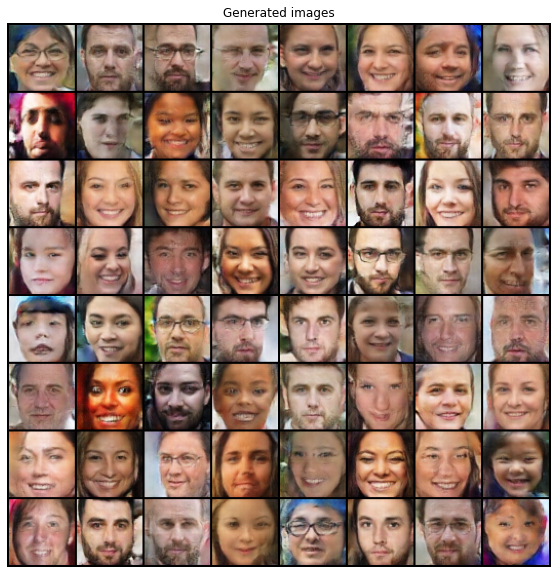

In [ ]:
generator.eval()
noise = torch.randn(64, 100, 1, 1, device=device)
sample_images = generator(noise).detach().cpu()
grid = vutils.make_grid(sample_images, nrow=8, normalize=True)
show(grid.cpu().detach().permute(1,2,0), sz=10, title='Generated images')

In [ ]:
img = grid.cpu().detach().permute(1,2,0)

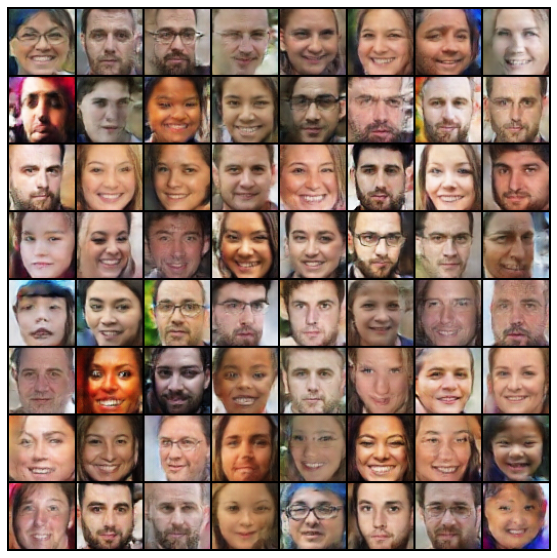

In [ ]:
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(img)
plt.savefig("dcgan_predictions.jpg")

In [ ]:
table = wandb.Table(columns=['Image'], allow_mixed_types = True)

table.add_data(
            wandb.Image("/content/dcgan_predictions.jpg"), 
        )

wandb.log({"Generated Images by DCGAN" : table})

In [ ]:
def save_table(table_name):
    table = wandb.Table(columns=['Image'], allow_mixed_types = True)

        table.add_data(
            id, 
            wandb.Image(img), 
            wandb.Image(mask),
            wandb.Image(cv2.cvtColor(cv2.imread("./image.jpg"), cv2.COLOR_BGR2RGB))
        )

    wandb.log({table_name : table})
     
save_table("Images and Masks Record")

---

## Wandb Dashboard

The runs and logs can be viewed in [this](https://wandb.ai/ishandutta/W&B_Generate_Faces_using_DCGAN?workspace=user-ishandutta) dashboard.

---